In [1]:
%matplotlib inline 
import matplotlib
import matplotlib.pyplot as plt


import time
import heatmap_setup as hm
import numpy as np


from SES_setup import *
from utils import *
from style import *
colourWheel =['#329932',
            '#ff6961',
            'b',
            '#6a3d9a',
            '#fb9a99',
            '#e31a1c',
            '#fdbf6f',
            '#ff7f00',
            '#cab2d6',
            '#6a3d9a',
            '#ffff99',
            '#b15928',
            '#67001f',
            '#b2182b',
            '#d6604d',
            '#f4a582',
            '#fddbc7',
            '#f7f7f7',
            '#d1e5f0',
            '#92c5de',
            '#4393c3',
            '#2166ac',
            '#053061'][::-1]
plt.rcParams['axes.labelsize'] = 25
plt.rcParams['legend.fontsize'] = 'large'

def steadystate_observable(ss_array, PARAMS, observable):
    ss_obs_array = np.zeros(shape=ss_array.shape)
    for y, ss_row in enumerate(ss_array):
        for x, ss_dm in enumerate(ss_row):
            dim, size = ss_dm.dims[0][1::], int(ss_dm.shape[0]/PARAMS['sys_dim'])
            
            nstates, state2idx, idx2state = qt.enr_state_dictionaries(dim, dim[0]+0)
            exc_diff = 0 # function finds the correct exc_diff given some dm
            while nstates != size:
                nstates, state2idx, idx2state = qt.enr_state_dictionaries(dim, dim[0]+exc_diff)
            
            #print exc_diff, dim[0]+exc_diff
            PARAMS.update({'N_1':dim[0], 'N_2':dim[1], 'exc':dim[0]+exc_diff})
            obs_op = make_expectation_operators(PARAMS)[observable]
            #print obs_op.shape, ss_dm.shape
            ss_obs_array[y][x] = (obs_op*ss_dm).tr().real #info_test[y][x]['solution_time']
    return ss_obs_array

# With saved data, we can calculte things differently

def heatmap_loader(num, dir_name="heatmap"):
    # Only loads data of heatmap into memory, does not plot
    directory = 'DATA/'+dir_name+'_'+str(num)
    ss_array = load_obj(directory+'/ss_array')
    PARAMS = load_obj(directory+'/PARAMS')
    info_array = load_obj(directory+'/info_array') # reverse ordering -> lower_N-higher_N
    return ss_array, PARAMS, info_array


def heatmap_plotter(num=-1, plot_SD=True, dir_name="heatmap", 
                     print_params=False, observable='sigma_x', ylim=False):
    
    # If ss_info_params list is provided, then makes heatmap from memory not disk
    
    if num>=0:
        ss_array, PARAMS, info_array = heatmap_loader(num, dir_name=dir_name)
        ss_array_add, PARAMS, info_array_add = heatmap_loader(num, dir_name=dir_name+'_add')
        data = {'non-add.': [ss_array,'solid'], 'add.': [ss_array_add, 'dashed']}
    info = info_array[0][0]
    try:
        # To catch an old bug where these were in "info" not in PARAMS
        keys = ['x_values', 'y_values', 'y_axis_parameters', 'x_axis_parameters']
        PARAMS.update(dict((key, info[key]) for key in keys))
    except Exception as err:
        print "plotting in new style"
    #print info
    
    if plot_SD:
        plot_UD_SD(PARAMS["Gamma_1"], PARAMS["alpha_1"], PARAMS["w0_1"], eps=8000.)
    eta = np.sqrt(PARAMS['bias']**2 + 4*PARAMS['V']**2)
    f, axes = plt.subplots(1,1, figsize=(13,6))
    for key in data.keys():
        if observable=='DS/GS':
            ss_arrayGS = steadystate_observable(data[key][0], PARAMS, 'OO')
            ss_arrayDS = steadystate_observable(data[key][0], PARAMS, 'dark')
            ss_arrayBS = steadystate_observable(data[key][0], PARAMS, 'bright')
            ss_array = (ss_arrayDS+ss_arrayBS)/ss_arrayGS
        else:
            ss_array = steadystate_observable(data[key][0], PARAMS, observable)
        
        ylab = ' = '.join(["$"+l+"$" for l in PARAMS['y_axis_parameters']])
        for i, y_val in enumerate(PARAMS['y_values']):
            x_values = PARAMS['x_values']

            lbl = ylab+"="+"{:0.1f}".format(y_val)
            if key == 'add.':
                lbl = None
            axes.plot(x_values, ss_array[i], label=lbl, 
                      linestyle=data[key][1], color=colourWheel[i*8])
            
        if print_params:
            print_PARAMS(PARAMS)
        labs = ("$\\"+l+"$" for l in PARAMS['x_axis_parameters'])
        xlab = ' , '.join(labs)
        
        plt.xlabel(xlab+" (cm$^{-1}$)")
        #plt.xlabel(', '.join(PARAMS['x_axis_parameters']))
        try:
            plt.ylabel(r"Steadystate "+make_expectation_labels()[observable])
        except:
            plt.ylabel(r"Steadystate "+observable)
    #plt.ylabel(', '.join(info['y_axis_parameters']))
    plt.legend()
    #plt.grid()
    plt.xlim(x_values[0], x_values[-1])
    if ylim:
        plt.ylim(ylim[0], ylim[-1])
    plot_filename = 'PLOTS/'+dir_name+'_'+observable+'_'+str(num)+'.pdf'
    plt.savefig(plot_filename,bbox_inches='tight')
    plt.show()
    print "saved at {}".format(plot_filename)

# Example of loading data to memory
"""ss_info_params = [ss_array, info_array, PARAMS]

heatmap_plotter(ss_info_params=ss_info_params, plot_SD=False,
                print_params=False, observable='sigma_x')
heatmap_plotter(num=5, plot_SD=False, dir_name="heatmap_excvN",
                print_params=False, observable='sigma_x')"""

SES_setup loaded globally


'ss_info_params = [ss_array, info_array, PARAMS]\n\nheatmap_plotter(ss_info_params=ss_info_params, plot_SD=False,\n                print_params=False, observable=\'sigma_x\')\nheatmap_plotter(num=5, plot_SD=False, dir_name="heatmap_excvN",\n                print_params=False, observable=\'sigma_x\')'

First things first, we look at heterodimers. Low-T and high-T on separate plots, to see whether additivity is pronounced or not. Then explore a higher RC frequency.

In [ ]:
reload(hm)
w_2 = 1.4*ev_to_inv_cm
bias=0.01*ev_to_inv_cm
V=0.01*ev_to_inv_cm
alpha = 200./pi
alpha_EM = 5.309e-3 # inv_ps_to_inv_cm *10^-3
N =4
wc = 100.
w_0 = 200.
site_basis = True
Gamma = (w_0**2)/wc
PARAMS = PARAMS_setup(bias=bias, w_2=w_2, 
                      V = V, alpha=alpha,
                      T_EM=6000., T_ph =300., alpha_EM=alpha_EM, shift=True,
                      num_cpus=4, N=N, Gamma=Gamma, w_0=w_0,
                      silent=True, exc_diff=2*N)

dirname = 'heatmap_hetero'


x_values = np.linspace(0.5,V, 30)

y_values = [77, 100] #np.linspace(77,300, 2)

"""

ss_array, info_array = hm.heat_map_calculator(PARAMS,
                            x_axis_parameters=['alpha_1', 'alpha_2'],
                            y_axis_parameters=['T_1', 'T_2'],
                            x_values=x_values,
                            y_values=y_values,
                            dir_name=dirname, save_data=True,
                            persistent=False, method='direct', threshold=1e-12, 
                                              conv_percent_tol=0.1, conv_obs='bright')
"""


In [ ]:
ss_array, info_array = hm.heat_map_calculator(PARAMS,
                            x_axis_parameters=['alpha_1', 'alpha_2'],
                            y_axis_parameters=['T_1', 'T_2'],
                            x_values=x_values,
                            y_values=y_values,
                            dir_name=dirname+'_add', save_data=True,
                            persistent=False, method='direct', threshold=1e-12, 
                                              conv_percent_tol=0.1, conv_obs='bright', additive=True)

In [ ]:
dirname = 'heatmap_hetero'
num=1
heatmap_plotter(num=num, plot_SD=True, dir_name=dirname,
                print_params=False, observable='bright')
heatmap_plotter(num=num, plot_SD=False, dir_name=dirname,
                print_params=False, observable='dark')
heatmap_plotter(num=num, plot_SD=False, dir_name=dirname,
                print_params=False, observable='sigma_z')
heatmap_plotter(num=num, plot_SD=False, dir_name=dirname,
                print_params=False, observable='sigma_x')
heatmap_plotter(num=num, plot_SD=False, dir_name=dirname,
                print_params=False, observable='eig_x')

In [4]:
dirname = 'heatmap_hetero'

In [8]:
reload(hm)
w_2 = 1.4*ev_to_inv_cm
bias=0.01*ev_to_inv_cm
V=0.01*ev_to_inv_cm
alpha = 200./pi
alpha_EM = 5.309e-3 # inv_ps_to_inv_cm *10^-3
N =4
wc = 100.
w_0 = 400.
site_basis = True
Gamma = 400.
PARAMS = PARAMS_setup(bias=bias, w_2=w_2, 
                      V = V, alpha=alpha,
                      T_EM=6000., T_ph =300., alpha_EM=alpha_EM, shift=True,
                      num_cpus=4, N=N, Gamma=Gamma, w_0=w_0,
                      silent=True, exc_diff=2*N)



x_values = np.linspace(0.5,100, 50)

y_values = [200.,600] #np.linspace(77,300, 2)

ss_array, info_array = hm.heat_map_calculator(PARAMS,
                            x_axis_parameters=['alpha_1', 'alpha_2'],
                            y_axis_parameters=['w0_1', 'w0_2'],
                            x_values=x_values,
                            y_values=y_values,
                            dir_name=dirname, save_data=True,
                            persistent=False, method='direct', threshold=0, 
                                              conv_percent_tol=0.05, 
                                              conv_obs='OO', N_min=5)

ss_array, info_array = hm.heat_map_calculator(PARAMS,
                            x_axis_parameters=['alpha_1', 'alpha_2'],
                            y_axis_parameters=['w0_1', 'w0_2'],
                            x_values=x_values,
                            y_values=y_values,
                            dir_name=dirname+'_add', save_data=True,
                            persistent=False, method='direct', threshold=0, 
                                              conv_percent_tol=0.05, conv_obs='OO', 
                                              additive=True, N_min=5)

alpha_1=0.50, w_1=11372.35, T_EM=6000.00, bias=80.66, parity_flip=0.00, w0_1=200.00, w0_2=200.00, V=80.66, T_2=300.00, T_1=300.00, Gamma_1=400.00, Gamma_2=400.00, dipole_2=1.00, dipole_1=1.00, exc=12.00, alpha_EM=0.01, sys_dim=3.00, N_1=4.00, N_2=4.00, mu=0.99, alpha_2=0.50, w_2=11291.70, w_xx=22664.06
None
Steady state for 5 took 0.481 seconds with direct, OO changed by 61.4415%
calculation converged - 0.5, 200.0 (1/100)
alpha_1=2.53, w_1=11372.35, kappa_1=12.53, kappa_2=12.53, T_EM=6000.00, bias=80.66, parity_flip=0.00, w0_1=200.00, w0_2=200.00, V=80.66, T_2=300.00, T_1=300.00, Gamma_1=400.00, Gamma_2=400.00, dipole_2=1.00, dipole_1=1.00, shift_2=0.79, exc=5.00, shift_1=0.79, alpha_EM=0.01, sys_dim=3.00, N_1=5.00, N_2=5.00, mu=0.99, alpha_2=2.53, w_2=11291.70, gamma_1=0.32, w_xx=22664.06, gamma_2=0.32
None
Steady state for 5 took 0.490 seconds with direct, OO changed by 168.5481%
Steady state for 6 took 3.143 seconds with direct, OO changed by 0.0021%
calculation converged - 2.5, 200

Steady state for 5 took 0.537 seconds with direct, OO changed by 9.5999%
Steady state for 6 took 2.860 seconds with direct, OO changed by 0.0221%
calculation converged - 28.9, 200.0 (15/100)
alpha_1=30.96, w_1=11372.35, kappa_1=95.33, kappa_2=95.33, T_EM=6000.00, bias=80.66, parity_flip=0.00, w0_1=200.00, w0_2=200.00, V=80.66, T_2=300.00, T_1=300.00, Gamma_1=400.00, Gamma_2=400.00, dipole_2=1.00, dipole_1=1.00, shift_2=45.44, exc=6.00, shift_1=45.44, alpha_EM=0.01, sys_dim=3.00, N_1=6.00, N_2=6.00, mu=0.99, alpha_2=30.96, w_2=11291.70, gamma_1=0.32, w_xx=22664.06, gamma_2=0.32
None
Steady state for 5 took 0.537 seconds with direct, OO changed by 7.2952%
Steady state for 6 took 2.412 seconds with direct, OO changed by 0.0236%
calculation converged - 31.0, 200.0 (16/100)
alpha_1=32.99, w_1=11372.35, kappa_1=98.62, kappa_2=98.62, T_EM=6000.00, bias=80.66, parity_flip=0.00, w0_1=200.00, w0_2=200.00, V=80.66, T_2=300.00, T_1=300.00, Gamma_1=400.00, Gamma_2=400.00, dipole_2=1.00, dipole_1=1.

Steady state for 5 took 0.509 seconds with direct, OO changed by 93.2141%
Steady state for 6 took 2.725 seconds with direct, OO changed by 0.0424%
calculation converged - 57.4, 200.0 (29/100)
alpha_1=59.39, w_1=11372.35, kappa_1=134.24, kappa_2=134.24, T_EM=6000.00, bias=80.66, parity_flip=0.00, w0_1=200.00, w0_2=200.00, V=80.66, T_2=300.00, T_1=300.00, Gamma_1=400.00, Gamma_2=400.00, dipole_2=1.00, dipole_1=1.00, shift_2=90.10, exc=6.00, shift_1=90.10, alpha_EM=0.01, sys_dim=3.00, N_1=6.00, N_2=6.00, mu=0.99, alpha_2=59.39, w_2=11291.70, gamma_1=0.32, w_xx=22664.06, gamma_2=0.32
None
Steady state for 5 took 0.494 seconds with direct, OO changed by 32.8124%
Steady state for 6 took 2.700 seconds with direct, OO changed by 0.0438%
calculation converged - 59.4, 200.0 (30/100)
alpha_1=61.42, w_1=11372.35, kappa_1=136.59, kappa_2=136.59, T_EM=6000.00, bias=80.66, parity_flip=0.00, w0_1=200.00, w0_2=200.00, V=80.66, T_2=300.00, T_1=300.00, Gamma_1=400.00, Gamma_2=400.00, dipole_2=1.00, dipol

Steady state for 5 took 0.494 seconds with direct, OO changed by 3.0416%
Steady state for 6 took 2.393 seconds with direct, OO changed by 0.0592%
Steady state for 7 took 13.112 seconds with direct, OO changed by 0.0351%
calculation converged - 83.8, 200.0 (42/100)
alpha_1=85.79, w_1=11372.35, kappa_1=162.21, kappa_2=162.21, T_EM=6000.00, bias=80.66, parity_flip=0.00, w0_1=200.00, w0_2=200.00, V=80.66, T_2=300.00, T_1=300.00, Gamma_1=400.00, Gamma_2=400.00, dipole_2=1.00, dipole_1=1.00, shift_2=131.56, exc=7.00, shift_1=131.56, alpha_EM=0.01, sys_dim=3.00, N_1=7.00, N_2=7.00, mu=0.99, alpha_2=85.79, w_2=11291.70, gamma_1=0.32, w_xx=22664.06, gamma_2=0.32
None
Steady state for 5 took 0.485 seconds with direct, OO changed by 329.2586%
Steady state for 6 took 2.927 seconds with direct, OO changed by 0.0604%
Steady state for 7 took 13.602 seconds with direct, OO changed by 0.0359%
calculation converged - 85.8, 200.0 (43/100)
alpha_1=87.82, w_1=11372.35, kappa_1=164.17, kappa_2=164.17, T_EM=

Steady state for 5 took 0.453 seconds with direct, OO changed by 6.3709%
Steady state for 6 took 2.879 seconds with direct, OO changed by 0.0000%
calculation converged - 8.6, 600.0 (55/100)
alpha_1=10.65, w_1=11372.35, kappa_1=90.15, kappa_2=90.15, T_EM=6000.00, bias=80.66, parity_flip=0.00, w0_1=600.00, w0_2=600.00, V=80.66, T_2=300.00, T_1=300.00, Gamma_1=400.00, Gamma_2=400.00, dipole_2=1.00, dipole_1=1.00, shift_2=13.54, exc=6.00, shift_1=13.54, alpha_EM=0.01, sys_dim=3.00, N_1=6.00, N_2=6.00, mu=0.99, alpha_2=10.65, w_2=11291.70, gamma_1=0.11, w_xx=22664.06, gamma_2=0.11
None
Steady state for 5 took 0.465 seconds with direct, OO changed by 4861.4596%
Steady state for 6 took 2.740 seconds with direct, OO changed by 0.0000%
calculation converged - 10.7, 600.0 (56/100)
alpha_1=12.68, w_1=11372.35, kappa_1=100.20, kappa_2=100.20, T_EM=6000.00, bias=80.66, parity_flip=0.00, w0_1=600.00, w0_2=600.00, V=80.66, T_2=300.00, T_1=300.00, Gamma_1=400.00, Gamma_2=400.00, dipole_2=1.00, dipole_

Steady state for 5 took 0.471 seconds with direct, OO changed by 33.7763%
Steady state for 6 took 2.757 seconds with direct, OO changed by 0.0002%
calculation converged - 37.1, 600.0 (69/100)
alpha_1=39.08, w_1=11372.35, kappa_1=186.87, kappa_2=186.87, T_EM=6000.00, bias=80.66, parity_flip=0.00, w0_1=600.00, w0_2=600.00, V=80.66, T_2=300.00, T_1=300.00, Gamma_1=400.00, Gamma_2=400.00, dipole_2=1.00, dipole_1=1.00, shift_2=58.20, exc=6.00, shift_1=58.20, alpha_EM=0.01, sys_dim=3.00, N_1=6.00, N_2=6.00, mu=0.99, alpha_2=39.08, w_2=11291.70, gamma_1=0.11, w_xx=22664.06, gamma_2=0.11
None
Steady state for 5 took 0.500 seconds with direct, OO changed by 10.1834%
Steady state for 6 took 2.745 seconds with direct, OO changed by 0.0002%
calculation converged - 39.1, 600.0 (70/100)
alpha_1=41.11, w_1=11372.35, kappa_1=191.92, kappa_2=191.92, T_EM=6000.00, bias=80.66, parity_flip=0.00, w0_1=600.00, w0_2=600.00, V=80.66, T_2=300.00, T_1=300.00, Gamma_1=400.00, Gamma_2=400.00, dipole_2=1.00, dipol

Steady state for 5 took 0.504 seconds with direct, OO changed by 24.2908%
Steady state for 6 took 2.648 seconds with direct, OO changed by 0.0007%
calculation converged - 65.5, 600.0 (83/100)
alpha_1=67.51, w_1=11372.35, kappa_1=248.42, kappa_2=248.42, T_EM=6000.00, bias=80.66, parity_flip=0.00, w0_1=600.00, w0_2=600.00, V=80.66, T_2=300.00, T_1=300.00, Gamma_1=400.00, Gamma_2=400.00, dipole_2=1.00, dipole_1=1.00, shift_2=102.86, exc=6.00, shift_1=102.86, alpha_EM=0.01, sys_dim=3.00, N_1=6.00, N_2=6.00, mu=0.99, alpha_2=67.51, w_2=11291.70, gamma_1=0.11, w_xx=22664.06, gamma_2=0.11
None
Steady state for 5 took 0.519 seconds with direct, OO changed by 69.9622%
Steady state for 6 took 2.904 seconds with direct, OO changed by 0.0007%
calculation converged - 67.5, 600.0 (84/100)
alpha_1=69.54, w_1=11372.35, kappa_1=252.24, kappa_2=252.24, T_EM=6000.00, bias=80.66, parity_flip=0.00, w0_1=600.00, w0_2=600.00, V=80.66, T_2=300.00, T_1=300.00, Gamma_1=400.00, Gamma_2=400.00, dipole_2=1.00, dip

Steady state for 5 took 0.512 seconds with direct, OO changed by 56.0426%
Steady state for 6 took 2.705 seconds with direct, OO changed by 0.0016%
calculation converged - 93.9, 600.0 (97/100)
alpha_1=95.94, w_1=11372.35, kappa_1=297.50, kappa_2=297.50, T_EM=6000.00, bias=80.66, parity_flip=0.00, w0_1=600.00, w0_2=600.00, V=80.66, T_2=300.00, T_1=300.00, Gamma_1=400.00, Gamma_2=400.00, dipole_2=1.00, dipole_1=1.00, shift_2=147.51, exc=6.00, shift_1=147.51, alpha_EM=0.01, sys_dim=3.00, N_1=6.00, N_2=6.00, mu=0.99, alpha_2=95.94, w_2=11291.70, gamma_1=0.11, w_xx=22664.06, gamma_2=0.11
None
Steady state for 5 took 0.527 seconds with direct, OO changed by 12.5677%
Steady state for 6 took 2.652 seconds with direct, OO changed by 0.0016%
calculation converged - 95.9, 600.0 (98/100)
alpha_1=97.97, w_1=11372.35, kappa_1=300.70, kappa_2=300.70, T_EM=6000.00, bias=80.66, parity_flip=0.00, w0_1=600.00, w0_2=600.00, V=80.66, T_2=300.00, T_1=300.00, Gamma_1=400.00, Gamma_2=400.00, dipole_2=1.00, dip

Steady state for 6 took 2.203 seconds with direct, OO changed by 0.0229%
calculation converged - 22.8, 200.0 (12/100)
kappa_2=84.70, kappa_1=84.70, T_EM=6000.00, bias=80.66, parity_flip=0.00, T_2=300.00, T_1=300.00, Gamma_1=400.00, Gamma_2=400.00, shift_2=35.87, shift_1=35.87, V=80.66, w_1=11372.35, w_2=11291.70, dipole_2=1.00, dipole_1=1.00, exc=6.00, alpha_EM=0.01, sys_dim=3.00, N_1=6.00, N_2=6.00, mu=0.99, w_xx=22664.06, gamma_1=0.32, gamma_2=0.32
None
Steady state for 5 took 0.387 seconds with direct, OO changed by 14.7654%
Steady state for 6 took 2.150 seconds with direct, OO changed by 0.0250%
calculation converged - 24.9, 200.0 (13/100)
kappa_2=88.39, kappa_1=88.39, T_EM=6000.00, bias=80.66, parity_flip=0.00, T_2=300.00, T_1=300.00, Gamma_1=400.00, Gamma_2=400.00, shift_2=39.06, shift_1=39.06, V=80.66, w_1=11372.35, w_2=11291.70, dipole_2=1.00, dipole_1=1.00, exc=6.00, alpha_EM=0.01, sys_dim=3.00, N_1=6.00, N_2=6.00, mu=0.99, w_xx=22664.06, gamma_1=0.32, gamma_2=0.32
None
Steady

Steady state for 5 took 0.386 seconds with direct, OO changed by 914.8599%
Steady state for 6 took 2.229 seconds with direct, OO changed by 0.0554%
Steady state for 7 took 12.445 seconds with direct, OO changed by 0.0320%
calculation converged - 55.3, 200.0 (28/100)
kappa_2=131.84, kappa_1=131.84, T_EM=6000.00, bias=80.66, parity_flip=0.00, T_2=300.00, T_1=300.00, Gamma_1=400.00, Gamma_2=400.00, shift_2=86.91, shift_1=86.91, V=80.66, w_1=11372.35, w_2=11291.70, dipole_2=1.00, dipole_1=1.00, exc=7.00, alpha_EM=0.01, sys_dim=3.00, N_1=7.00, N_2=7.00, mu=0.99, w_xx=22664.06, gamma_1=0.32, gamma_2=0.32
None
Steady state for 5 took 0.399 seconds with direct, OO changed by 1427.5477%
Steady state for 6 took 2.140 seconds with direct, OO changed by 0.0574%
Steady state for 7 took 12.326 seconds with direct, OO changed by 0.0333%
calculation converged - 57.4, 200.0 (29/100)
kappa_2=134.24, kappa_1=134.24, T_EM=6000.00, bias=80.66, parity_flip=0.00, T_2=300.00, T_1=300.00, Gamma_1=400.00, Gamma

Steady state for 5 took 0.392 seconds with direct, OO changed by 66.3404%
Steady state for 6 took 2.255 seconds with direct, OO changed by 0.0823%
Steady state for 7 took 12.472 seconds with direct, OO changed by 0.0494%
calculation converged - 83.8, 200.0 (42/100)
kappa_2=162.21, kappa_1=162.21, T_EM=6000.00, bias=80.66, parity_flip=0.00, T_2=300.00, T_1=300.00, Gamma_1=400.00, Gamma_2=400.00, shift_2=131.56, shift_1=131.56, V=80.66, w_1=11372.35, w_2=11291.70, dipole_2=1.00, dipole_1=1.00, exc=7.00, alpha_EM=0.01, sys_dim=3.00, N_1=7.00, N_2=7.00, mu=0.99, w_xx=22664.06, gamma_1=0.32, gamma_2=0.32
None
Steady state for 5 took 0.387 seconds with direct, OO changed by 15.3574%
Steady state for 6 took 2.293 seconds with direct, OO changed by 0.0842%
Steady state for 7 took 12.211 seconds with direct, OO changed by 0.0507%
Steady state for 8 took 39.341 seconds with direct, OO changed by 0.0297%
calculation converged - 85.8, 200.0 (43/100)
kappa_2=164.17, kappa_1=164.17, T_EM=6000.00, bi

Steady state for 6 took 1.750 seconds with direct, OO changed by 0.0000%
calculation converged - 8.6, 600.0 (55/100)
kappa_2=90.15, kappa_1=90.15, T_EM=6000.00, bias=80.66, parity_flip=0.00, T_2=300.00, T_1=300.00, Gamma_1=400.00, Gamma_2=400.00, shift_2=13.54, shift_1=13.54, V=80.66, w_1=11372.35, w_2=11291.70, dipole_2=1.00, dipole_1=1.00, exc=6.00, alpha_EM=0.01, sys_dim=3.00, N_1=6.00, N_2=6.00, mu=0.99, w_xx=22664.06, gamma_1=0.11, gamma_2=0.11
None
Steady state for 5 took 0.383 seconds with direct, OO changed by 84.2571%
Steady state for 6 took 2.060 seconds with direct, OO changed by 0.0000%
calculation converged - 10.7, 600.0 (56/100)
kappa_2=100.20, kappa_1=100.20, T_EM=6000.00, bias=80.66, parity_flip=0.00, T_2=300.00, T_1=300.00, Gamma_1=400.00, Gamma_2=400.00, shift_2=16.73, shift_1=16.73, V=80.66, w_1=11372.35, w_2=11291.70, dipole_2=1.00, dipole_1=1.00, exc=6.00, alpha_EM=0.01, sys_dim=3.00, N_1=6.00, N_2=6.00, mu=0.99, w_xx=22664.06, gamma_1=0.11, gamma_2=0.11
None
Stead

Steady state for 5 took 0.382 seconds with direct, OO changed by 158.7812%
Steady state for 6 took 2.021 seconds with direct, OO changed by 0.0004%
calculation converged - 41.1, 600.0 (71/100)
kappa_2=196.84, kappa_1=196.84, T_EM=6000.00, bias=80.66, parity_flip=0.00, T_2=300.00, T_1=300.00, Gamma_1=400.00, Gamma_2=400.00, shift_2=64.58, shift_1=64.58, V=80.66, w_1=11372.35, w_2=11291.70, dipole_2=1.00, dipole_1=1.00, exc=6.00, alpha_EM=0.01, sys_dim=3.00, N_1=6.00, N_2=6.00, mu=0.99, w_xx=22664.06, gamma_1=0.11, gamma_2=0.11
None
Steady state for 5 took 0.407 seconds with direct, OO changed by 64.6860%
Steady state for 6 took 1.871 seconds with direct, OO changed by 0.0004%
calculation converged - 43.1, 600.0 (72/100)
kappa_2=201.65, kappa_1=201.65, T_EM=6000.00, bias=80.66, parity_flip=0.00, T_2=300.00, T_1=300.00, Gamma_1=400.00, Gamma_2=400.00, shift_2=67.77, shift_1=67.77, V=80.66, w_1=11372.35, w_2=11291.70, dipole_2=1.00, dipole_1=1.00, exc=6.00, alpha_EM=0.01, sys_dim=3.00, N_1

Steady state for 5 took 0.496 seconds with direct, OO changed by 493.0038%
Steady state for 6 took 1.755 seconds with direct, OO changed by 0.0014%
calculation converged - 73.6, 600.0 (87/100)
kappa_2=263.38, kappa_1=263.38, T_EM=6000.00, bias=80.66, parity_flip=0.00, T_2=300.00, T_1=300.00, Gamma_1=400.00, Gamma_2=400.00, shift_2=115.61, shift_1=115.61, V=80.66, w_1=11372.35, w_2=11291.70, dipole_2=1.00, dipole_1=1.00, exc=6.00, alpha_EM=0.01, sys_dim=3.00, N_1=6.00, N_2=6.00, mu=0.99, w_xx=22664.06, gamma_1=0.11, gamma_2=0.11
None
Steady state for 5 took 0.365 seconds with direct, OO changed by 1411.0728%
Steady state for 6 took 2.232 seconds with direct, OO changed by 0.0015%
calculation converged - 75.6, 600.0 (88/100)
kappa_2=266.99, kappa_1=266.99, T_EM=6000.00, bias=80.66, parity_flip=0.00, T_2=300.00, T_1=300.00, Gamma_1=400.00, Gamma_2=400.00, shift_2=118.80, shift_1=118.80, V=80.66, w_1=11372.35, w_2=11291.70, dipole_2=1.00, dipole_1=1.00, exc=6.00, alpha_EM=0.01, sys_dim=3.0

plotting in new style


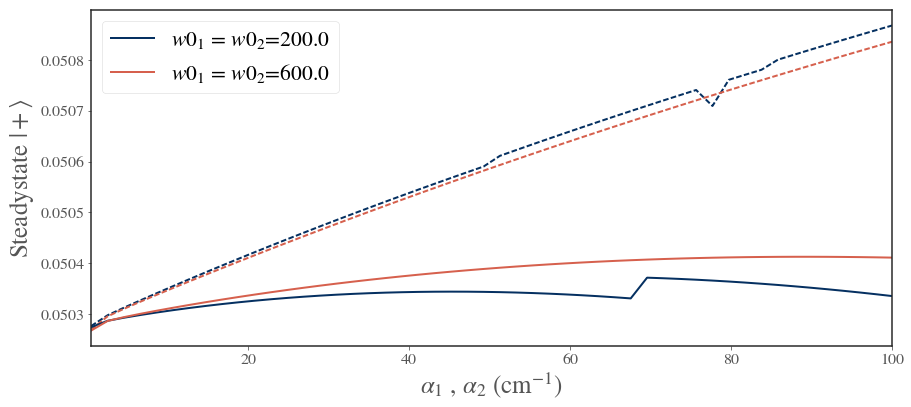

saved at PLOTS/heatmap_hetero_bright_7.pdf
plotting in new style


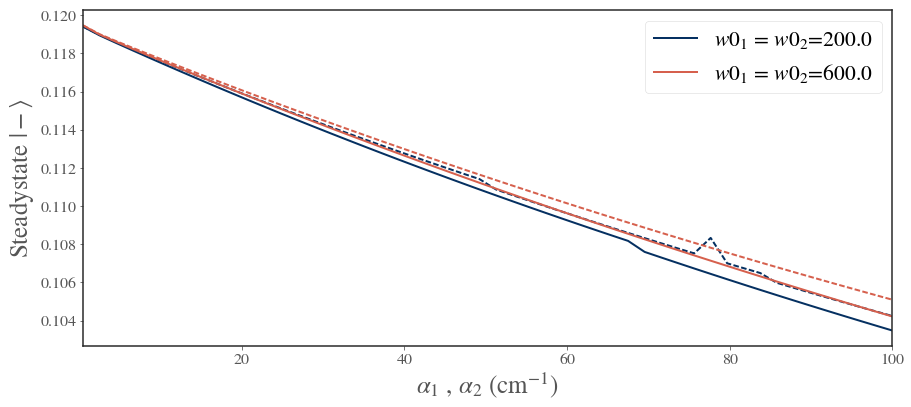

saved at PLOTS/heatmap_hetero_dark_7.pdf
plotting in new style


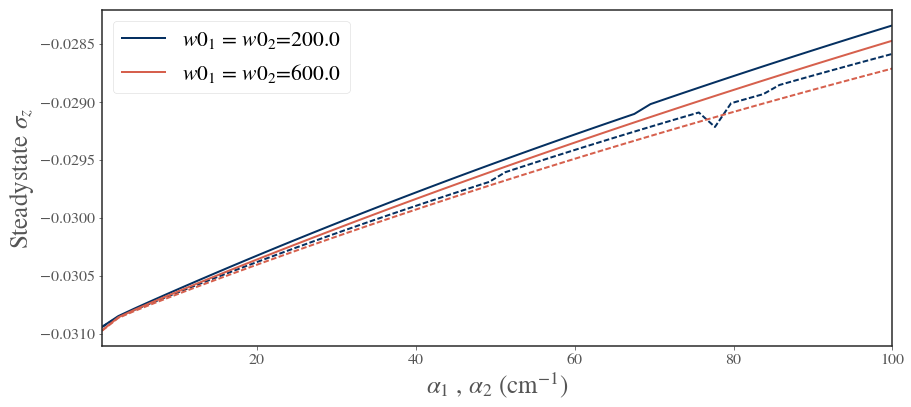

saved at PLOTS/heatmap_hetero_sigma_z_7.pdf
plotting in new style


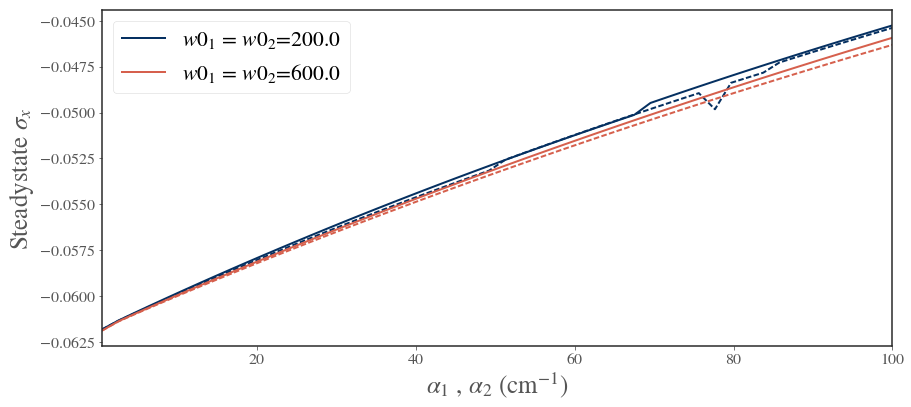

saved at PLOTS/heatmap_hetero_sigma_x_7.pdf
plotting in new style


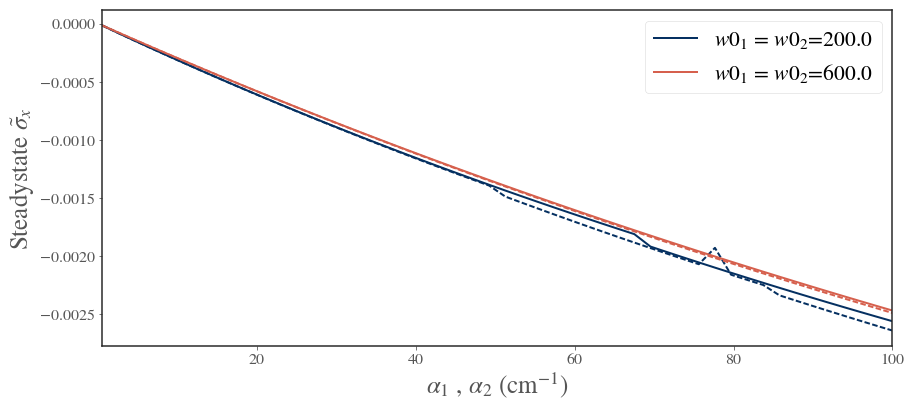

saved at PLOTS/heatmap_hetero_eig_x_7.pdf


In [9]:
num=7
heatmap_plotter(num=num, plot_SD=False, dir_name=dirname,
                print_params=False, observable='bright')
heatmap_plotter(num=num, plot_SD=False, dir_name=dirname,
                print_params=False, observable='dark')
heatmap_plotter(num=num, plot_SD=False, dir_name=dirname,
                print_params=False, observable='sigma_z')
heatmap_plotter(num=num, plot_SD=False, dir_name=dirname,
                print_params=False, observable='sigma_x')
heatmap_plotter(num=num, plot_SD=False, dir_name=dirname,
                print_params=False, observable='eig_x')

In [ ]:
reload(hm)
w_2 = 1.4*ev_to_inv_cm
bias=0.01*ev_to_inv_cm
V=0.01*ev_to_inv_cm
alpha = 200./pi
alpha_EM = 5.309e-3 # inv_ps_to_inv_cm *10^-3
N =4
wc = 100.
w_0 = 200.
site_basis = True
Gamma = (w_0**2)/wc
PARAMS = PARAMS_setup(bias=bias, w_2=w_2, 
                      V = V, alpha=alpha,
                      T_EM=6000., T_ph =300., alpha_EM=alpha_EM, shift=True,
                      num_cpus=4, N=N, Gamma=Gamma, w_0=w_0,
                      silent=True, exc_diff=2*N)

dirname = 'heatmap_hetero'


x_values = np.linspace(0.5,V, 30)

y_values = [300.] #np.linspace(77,300, 2)



ss_array, info_array = hm.heat_map_calculator(PARAMS,
                            x_axis_parameters=['alpha_1', 'alpha_2'],
                            y_axis_parameters=['T_1', 'T_2'],
                            x_values=x_values,
                            y_values=y_values,
                            dir_name=dirname, save_data=True,
                            persistent=False, method='direct', threshold=1e-12, 
                                              conv_percent_tol=0.1, conv_obs='bright')
ss_array, info_array = hm.heat_map_calculator(PARAMS,
                            x_axis_parameters=['alpha_1', 'alpha_2'],
                            y_axis_parameters=['T_1', 'T_2'],
                            x_values=x_values,
                            y_values=y_values,
                            dir_name=dirname+'_add', save_data=True,
                            persistent=False, method='direct', threshold=1e-12, 
                                              conv_percent_tol=0.1, conv_obs='bright', additive=True)

### Uncoupled monomers

These get updated dynamically by the various functions. `SES_setup.PARAMS_setup` just imposes the relevant symmetry behind the scenes so the API is clean and so that we can reuse code for dimer case - e.g. $\alpha_1 = \alpha_2$, no doubly excited state.

In [ ]:

w_2 = 1.4*ev_to_inv_cm
bias = 0.02*ev_to_inv_cm #0.0000001*ev_to_inv_cm
V = 0.0*ev_to_inv_cm #0.00001*ev_to_inv_cm
alpha = 100./pi
alpha_EM = 5.309e-3 # inv_ps_to_inv_cm *10^-3
N =7
wc = 100.
w_0 = 200.
site_basis = True
Gamma = (w_0**2)/wc
PARAMS = PARAMS_setup(bias=bias, w_2=w_2, 
                      V = V, alpha=alpha,
                      T_EM=6000., T_ph =300., alpha_EM=alpha_EM, shift=True,
                      num_cpus=4, N=N, Gamma=Gamma, w_0=w_0,
                      silent=False, exc_diff=N)

x_values = np.logspace(-2, np.log10(100), 10, endpoint=True)
print x_values
y_values = [77, 300] #np.linspace(77,300, 2)
dirname = 'heatmap_TphvAlpha_uncoupled'

ss_array, info_array = hm.heat_map_calculator(PARAMS,
                            x_axis_parameters=['alpha_1', 'alpha_2'],
                            y_axis_parameters=['T_1', 'T_2'],
                            x_values=x_values,
                            y_values=y_values,
                            dir_name=dirname+'_add', save_data=True,
                            persistent=False, method='direct', threshold=1e-12, 
                                              conv_percent_tol=0.025, conv_obs='OO', additive=True)
"""
ss_array, info_array = hm.heat_map_calculator(PARAMS,
                            x_axis_parameters=['alpha_1', 'alpha_2'],
                            y_axis_parameters=['T_1', 'T_2'],
                            x_values=x_values,
                            y_values=y_values,
                            dir_name=dirname, save_data=True,
                            persistent=False, method='direct', threshold=1e-12, 
                            conv_percent_tol=0.01, conv_obs='OO', additive=False)
"""
#DATA/heatmap_TphvAlpha_uncoupled_6

In [ ]:
num=7
dirname = 'heatmap_TphvAlpha_uncoupled'
heatmap_plotter(num=num, plot_SD=False, dir_name=dirname,
                print_params=False, observable='XO')
heatmap_plotter(num=num, plot_SD=False, dir_name=dirname,
                print_params=False, observable='OX')

In [ ]:
H, L = get_H_and_L(PARAMS)


In [ ]:
eta = np.sqrt(PARAMS['bias']**2 + 4*PARAMS['V']**2)
print (2*PARAMS['V']/eta)
print (PARAMS['bias']/eta)
print (1/np.sqrt(2))

In [ ]:
np.linspace(200, 600, 5, endpoint=False)

In [ ]:
np.log(0.0001)
np.logspace(-5, 2, 10, endpoint=False)

## Heterodimer
Shouldn't increasing the phonon coupling strength lead to suppression of ground state population?

In [ ]:
ss_array, PARAMS, info_array = heatmap_loader(16, dir_name="heatmap_TphvAlpha")
print zip(PARAMS['x_values'], steadystate_observable(ss_array, PARAMS, 'OO')[0])

In [ ]:

reload(hm)
"""
ss_array, info_array = hm.heat_map_calculator(PARAMS,
                            x_axis_parameters=['alpha_1', 'alpha_2'],
                            y_axis_parameters=['T_1', 'T_2'],
                            x_values=x_values,
                            y_values=y_values,
                            dir_name=dirname, save_data=True,
                            persistent=False, method='direct', threshold=1e-12, 
                            conv_percent_tol=0.025, conv_obs='OO', additive=False)
"""
ss_array, info_array = hm.heat_map_calculator(PARAMS,
                            x_axis_parameters=['alpha_1', 'alpha_2'],
                            y_axis_parameters=['T_1', 'T_2'],
                            x_values=x_values,
                            y_values=y_values,
                            dir_name=dirname+'_add', save_data=True,
                            persistent=False, method='direct', threshold=1e-12, 
                                              conv_percent_tol=0.025, conv_obs='OO', additive=True)

In [ ]:
dirname = 'heatmap_TphvAlpha_hetero'
num = 5
heatmap_plotter(num=num, plot_SD=False, dir_name=dirname,
                print_params=False, observable='bright')
heatmap_plotter(num=num, plot_SD=False, dir_name=dirname,
                print_params=False, observable='dark')
heatmap_plotter(num=num, plot_SD=False, dir_name=dirname,
                print_params=False, observable='sigma_z')
heatmap_plotter(num=num, plot_SD=False, dir_name=dirname,
                print_params=False, observable='sigma_x')
heatmap_plotter(num=num, plot_SD=False, dir_name=dirname,
                print_params=False, observable='eig_x')

In [ ]:
num = 20
heatmap_plotter(num=num, plot_SD=False, dir_name=dirname,
                print_params=False, observable='DS/GS')

heatmap_plotter(num=num, plot_SD=False, dir_name=dirname,
                print_params=False, observable='OO')

heatmap_plotter(num=num, plot_SD=False, dir_name=dirname,
                print_params=False, observable='XO')
heatmap_plotter(num=num, plot_SD=False, dir_name=dirname,
                print_params=False, observable='OX')

heatmap_plotter(num=num, plot_SD=False, dir_name=dirname,
                print_params=False, observable='eig_x')
"""heatmap_plotter(num=num, plot_SD=False, dir_name="heatmap_TphvAlpha",
                print_params=False, observable='eig_x_equiv')
heatmap_plotter(num=num, plot_SD=False, dir_name="heatmap_TphvAlpha",
                print_params=False, observable='eig_y')"""




# Homodimer

In [ ]:
reload(hm)
w_2 = 1.40*ev_to_inv_cm
bias= 0 #0.01*ev_to_inv_cm
V=0.01*ev_to_inv_cm
alpha = 200./pi
alpha_EM = 5.309e-3 # inv_ps_to_inv_cm *10^-3
N =4
wc = 100.
w_0 = 200.
site_basis = True
Gamma = (w_0**2)/wc
PARAMS = PARAMS_setup(bias=bias, w_2=w_2, 
                      V = V, alpha=alpha,
                      T_EM=6000., T_ph =300., alpha_EM=alpha_EM, shift=True,
                      num_cpus=4, N=N, Gamma=Gamma, w_0=w_0,
                      silent=True, exc_diff=2*N)

x_values = np.logspace(-2, np.log10(100), 10, endpoint=True)
#x_values[0] = 0
y_values = [77, 300] #np.linspace(77,300, 2)


In [ ]:
print inv_ps_to_inv_cm*10**(-3)
print w_0/ev_to_inv_cm
print Gamma/ev_to_inv_cm

In [ ]:
print (x_values)

In [ ]:
dirname = 'heatmap_TphvAlpha_homo'
reload(hm)

ss_array, info_array = hm.heat_map_calculator(PARAMS,
                            x_axis_parameters=['alpha_1', 'alpha_2'],
                            y_axis_parameters=['T_1', 'T_2'],
                            x_values=x_values,
                            y_values=y_values,
                            dir_name=dirname, save_data=True,
                            persistent=False, method='direct', threshold=1e-12, 
                                              conv_percent_tol=0.025, conv_obs='OO', additive=False)

"""
ss_array, info_array = hm.heat_map_calculator(PARAMS,
                            x_axis_parameters=['alpha_1', 'alpha_2'],
                            y_axis_parameters=['T_1', 'T_2'],
                            x_values=x_values,
                            y_values=y_values,
                            dir_name=dirname+'_add', save_data=True,
                            persistent=False, method='direct', threshold=1e-12, 
                                              conv_percent_tol=0.025, conv_obs='OO', additive=True)"""

In [ ]:
def steadystate_observable(ss_array, PARAMS, observable):
    ss_obs_array = np.zeros(shape=ss_array.shape)
    for y, ss_row in enumerate(ss_array):
        for x, ss_dm in enumerate(ss_row):
            dim, size = ss_dm.dims[0][1::], int(ss_dm.shape[0]/PARAMS['sys_dim'])
            
            nstates, state2idx, idx2state = qt.enr_state_dictionaries(dim, dim[0]+0)
            exc_diff = 0 # function finds the correct exc_diff given some dm
            while nstates != size:
                nstates, state2idx, idx2state = qt.enr_state_dictionaries(dim, dim[0]+exc_diff)
            
            #print exc_diff, dim[0]+exc_diff
            PARAMS.update({'N_1':dim[0], 'N_2':dim[1], 'exc':dim[0]+exc_diff})
            obs_op = make_expectation_operators(PARAMS)[observable]
            #print obs_op.shape, ss_dm.shape
            ss_obs_array[y][x] = (obs_op*ss_dm).tr().real #info_test[y][x]['solution_time']
    return ss_obs_array

# With saved data, we can calculte things differently

def heatmap_loader(num, dir_name="heatmap"):
    # Only loads data of heatmap into memory, does not plot
    directory = 'DATA/'+dir_name+'_'+str(num)
    ss_array = load_obj(directory+'/ss_array')
    PARAMS = load_obj(directory+'/PARAMS')
    info_array = load_obj(directory+'/info_array') # reverse ordering -> lower_N-higher_N
    return ss_array, PARAMS, info_array

dirname = 'heatmap_TphvAlpha_homo'
num = 3
heatmap_plotter(num=num, dir_name=dirname, 
                     print_params=False, observable='XO')
heatmap_plotter(num=num, dir_name=dirname, 
                     print_params=False, observable='dark')
heatmap_plotter(num=num, dir_name=dirname, 
                     print_params=False, observable='bright')
heatmap_plotter(num=num, dir_name=dirname, 
                     print_params=False, observable='sigma_x')


In [ ]:
num = 3
dirname = 'heatmap_TphvAlpha_homo'
heatmap_plotter(num=num, plot_SD=False, dir_name="heatmap_TphvAlpha",
                print_params=True, observable='DS/GS')
heatmap_plotter(num=num, plot_SD=False, dir_name="heatmap_TphvAlpha",
                print_params=False, observable='bright')
heatmap_plotter(num=num, plot_SD=False, dir_name="heatmap_TphvAlpha",
                print_params=False, observable='dark')
heatmap_plotter(num=num, plot_SD=False, dir_name="heatmap_TphvAlpha",
                print_params=False, observable='OO')

heatmap_plotter(num=num, plot_SD=False, dir_name="heatmap_TphvAlpha",
                print_params=False, observable='XO')
heatmap_plotter(num=num, plot_SD=False, dir_name="heatmap_TphvAlpha",
                print_params=False, observable='OX')

heatmap_plotter(num=num, plot_SD=False, dir_name="heatmap_TphvAlpha",
                print_params=False, observable='eig_x')
heatmap_plotter(num=num, plot_SD=False, dir_name="heatmap_TphvAlpha",
                print_params=False, observable='eig_x_equiv')
heatmap_plotter(num=num, plot_SD=False, dir_name="heatmap_TphvAlpha",
                print_params=False, observable='eig_y')

heatmap_plotter(num=num, plot_SD=False, dir_name="heatmap_TphvAlpha",
                print_params=False, observable='sigma_z')
heatmap_plotter(num=num, plot_SD=False, dir_name="heatmap_TphvAlpha",
                print_params=False, observable='sigma_x')
heatmap_plotter(num=num, plot_SD=False, dir_name="heatmap_TphvAlpha",
                print_params=False, observable='sigma_y')

In [ ]:
num = 1
dir_name = 'heatmap_TphvAlpha_a19'
hm = heatmap_loader(19, dir_name='heatmap_TphvAlpha')
hm2 = heatmap_loader(1, dir_name='heatmap_TphvAlpha_a19')
print hm[0]
"""heatmap_plotter(num=num, plot_SD=False, dir_name=dir_name,
                print_params=True, observable='DS/GS')
heatmap_plotter(num=num, plot_SD=False, dir_name=dir_name,
                print_params=False, observable='bright')
heatmap_plotter(num=num, plot_SD=False, dir_name=dir_name,
                print_params=False, observable='dark')
heatmap_plotter(num=num, plot_SD=False, dir_name=dir_name,
                print_params=False, observable='OO')

heatmap_plotter(num=num, plot_SD=False, dir_name=dir_name,
                print_params=False, observable='XO')
heatmap_plotter(num=num, plot_SD=False, dir_name=dir_name,
                print_params=False, observable='OX')

heatmap_plotter(num=num, plot_SD=False, dir_name=dir_name,
                print_params=False, observable='eig_x')
heatmap_plotter(num=num, plot_SD=False, dir_name=dir_name,
                print_params=False, observable='eig_x_equiv')
heatmap_plotter(num=num, plot_SD=False, dir_name=dir_name,
                print_params=False, observable='eig_y')

heatmap_plotter(num=num, plot_SD=False, dir_name=dir_name,
                print_params=False, observable='sigma_z')
heatmap_plotter(num=num, plot_SD=False, dir_name=dir_name,
                print_params=False, observable='sigma_x')
heatmap_plotter(num=num, plot_SD=False, dir_name=dir_name,
                print_params=False, observable='sigma_y')"""

# Asymmetrical phonon environments

In [ ]:
reload(hm)
w_2 = 1.40*ev_to_inv_cm
bias= 0 #0.01*ev_to_inv_cm
V=0.01*ev_to_inv_cm
alpha = 5.
alpha_EM = 5.309e-3 # inv_ps_to_inv_cm *10^-3
N =4
wc = 100.
w_0 = 200.
site_basis = True
Gamma = (w_0**2)/wc
PARAMS = PARAMS_setup(bias=bias, w_2=w_2, 
                      V = V, alpha=alpha,
                      T_EM=6000., T_ph =300., alpha_EM=alpha_EM, shift=True,
                      num_cpus=4, N=N, Gamma=Gamma, w_0=w_0,
                      silent=True, exc_diff=2*N)

x_values = np.logspace(-2, np.log10(100), 20, endpoint=True)
#x_values[0] = 0
y_values = [77, 300] #np.linspace(77,300, 2)
dirname = "heatmap_TphvAlpha_assymmetrical"
"""
ss_array, info_array = hm.heat_map_calculator(PARAMS,
                            x_axis_parameters=['alpha_1'],
                            y_axis_parameters=['T_1', 'T_2'],
                            x_values=x_values,
                            y_values=y_values,
                            dir_name=dirname, save_data=True,
                            persistent=False, method='direct', threshold=1e-7, 
                                              conv_percent_tol=0.025, conv_obs='OO')
"""
ss_array, info_array = hm.heat_map_calculator(PARAMS,
                            x_axis_parameters=['alpha_1'],
                            y_axis_parameters=['T_1', 'T_2'],
                            x_values=x_values,
                            y_values=y_values,
                            dir_name=dirname+'_add', save_data=True,
                            persistent=False, method='direct', threshold=1e-7, 
                                              conv_percent_tol=0.025, conv_obs='OO', additive=True)

In [ ]:
num = 1
dirname = "heatmap_TphvAlpha_assymmetrical"
#heatmap_plotter(num=num, plot_SD=False, dir_name=dirname,
#                print_params=True, observable='DS/GS')
heatmap_plotter(num=num, plot_SD=False, dir_name=dirname,
                print_params=False, observable='bright')
heatmap_plotter(num=num, plot_SD=False, dir_name=dirname,
                print_params=False, observable='dark')
heatmap_plotter(num=num, plot_SD=False, dir_name=dirname,
                print_params=False, observable='OO')

heatmap_plotter(num=num, plot_SD=False, dir_name=dirname,
                print_params=False, observable='XO')
heatmap_plotter(num=num, plot_SD=False, dir_name=dirname,
                print_params=False, observable='OX')

heatmap_plotter(num=num, plot_SD=False, dir_name=dirname,
                print_params=False, observable='eig_x')
heatmap_plotter(num=num, plot_SD=False, dir_name=dirname,
                print_params=False, observable='eig_x_equiv')
heatmap_plotter(num=num, plot_SD=False, dir_name=dirname,
                print_params=False, observable='eig_y')

heatmap_plotter(num=num, plot_SD=False, dir_name=dirname,
                print_params=False, observable='sigma_z')
heatmap_plotter(num=num, plot_SD=False, dir_name=dirname,
                print_params=False, observable='sigma_x')
heatmap_plotter(num=num, plot_SD=False, dir_name=dirname,
                print_params=False, observable='sigma_y')

# Environments with different parity $\alpha_1 = -\alpha_2$

In [ ]:
reload(hm)
w_2 = 1.4*ev_to_inv_cm
bias = 0.01*ev_to_inv_cm #0.0000001*ev_to_inv_cm
V = 0.01*ev_to_inv_cm #0.00001*ev_to_inv_cm
alpha = 100./pi
alpha_EM = 5.309e-3 # inv_ps_to_inv_cm *10^-3
N =7
wc = 100.
w_0 = 200.
site_basis = True
Gamma = (w_0**2)/wc
PARAMS = PARAMS_setup(bias=bias, w_2=w_2, 
                      V = V, alpha=alpha,
                      T_EM=6000., T_ph =300., alpha_EM=alpha_EM, shift=True,
                      num_cpus=4, N=N, Gamma=Gamma, w_0=w_0,
                      silent=False, exc_diff=N, parity_flip=True)
print 
x_values = np.linspace(0.5,V, 30)
print x_values
y_values = [77, 110] #np.linspace(77,300, 2)
dirname = 'heatmap_TphvAlpha_phased'

ss_array, info_array = hm.heat_map_calculator(PARAMS,
                            x_axis_parameters=['alpha_1', 'alpha_2'],
                            y_axis_parameters=['T_1', 'T_2'],
                            x_values=x_values,
                            y_values=y_values,
                            dir_name=dirname+'_add', save_data=True,
                            persistent=False, method='direct', threshold=1e-9, 
                            conv_percent_tol=0.025, conv_obs='OO', additive=True)
"""
ss_array, info_array = hm.heat_map_calculator(PARAMS,
                            x_axis_parameters=['alpha_1', 'alpha_2'],
                            y_axis_parameters=['T_1', 'T_2'],
                            x_values=x_values,
                            y_values=y_values,
                            dir_name=dirname, save_data=True,
                            persistent=False, method='direct', threshold=1e-9, 
                            conv_percent_tol=0.025, conv_obs='OO', additive=False)"""
#DATA/heatmap_TphvAlpha_phased_2

In [ ]:
num=3
dirname = 'heatmap_TphvAlpha_phased'
heatmap_plotter(num=num, plot_SD=False, dir_name=dirname,
                print_params=False, observable='XO', ylim=[0,0.2])
heatmap_plotter(num=num, plot_SD=False, dir_name=dirname,
                print_params=False, observable='OX', ylim=[0.1,0.5])
heatmap_plotter(num=num, plot_SD=False, dir_name=dirname,
                print_params=False, observable='dark', ylim=[0,0.6])
heatmap_plotter(num=num, plot_SD=False, dir_name=dirname,
                print_params=False, observable='bright', ylim=[-0.01,0.1])
heatmap_plotter(num=num, plot_SD=False, dir_name=dirname,
                print_params=False, observable='eig_x')